# Relax
## The   data   is   available   as   two   attached  CSV   files:    takehome_user_engagement.csv takehome_users.csv

In [1]:
#import all necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from pylab import plot, show
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

### Reading all data as dataframes named 'engage' and 'users'. 

In [2]:
#Reading the csv files
engage = pd.read_csv('./takehome_user_engagement.csv')

In [3]:
engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [4]:
users = pd.read_csv('./takehome_users.csv', delimiter  = ',',encoding='"ISO-8859-1"')

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


### Select users who loggined into product at least 3 times in 7 day periods

In [6]:
engage = engage.groupby('user_id').filter(lambda x: len(x) >= 3)
engage.reset_index(drop=True, inplace = True) 
engage.shape[0]

201002

In [7]:
#this sequence runs through the dataframe, creates a week from a date, and then checks if the next two dates fall within that
#time. Then it ouputs the user_id to a list.
active = -1
active_users = []
for i in range(engage.shape[0]-2):
    user = engage['user_id'][i] #get current user_id
    if user != active and user == engage['user_id'][i+2]: #so we can skip a user that has already been active and to make sure we don't compare to the next user
        st = pd.Timestamp(engage['time_stamp'][i]) #get start date
        et = st + pd.Timedelta('7D') # make range for end date
        if st < pd.Timestamp(engage['time_stamp'][i+1]) < et and st < pd.Timestamp(engage['time_stamp'][i+2]) < et:
            active_users.append(user) # now that the active condition has been met, return that user
            active = user                  #define the user as active

In [8]:
len(active_users)  

1602

In [9]:
users['active'] = 0
users.loc[users['object_id'].isin(active_users),'active'] = 1.0

### create new variable 'active' to decribe the active users: active set to 1 and non-active set to 0

In [10]:
users.loc[users['invited_by_user_id']>=1,'invited_by_user_id'] = 1.0
users.loc[users['invited_by_user_id'].isnull(),'invited_by_user_id'] = 0.0
users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,1.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,1.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,1.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,1.0,0.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,1.0,0.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,0.0,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,0.0,0.0
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,0.0,0.0
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,1.0,1.0


In [11]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
active                        12000 non-null float64
dtypes: float64(3), int64(4), object(4)
memory usage: 1.0+ MB


In [12]:
le = preprocessing.LabelEncoder()
le.fit(['ORG_INVITE','GUEST_INVITE','PERSONAL_PROJECTS','SIGNUP','SIGNUP_GOOGLE_AUTH'])

LabelEncoder()

In [13]:
creation = le.transform(users['creation_source'])
df = pd.DataFrame(creation,columns = ['creation'])
users = pd.concat([users,df],axis=1)

In [14]:
y = users['active']
X = users[['creation','last_session_creation_time','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id']]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Text(0,0.5,'Feature Importance Score')

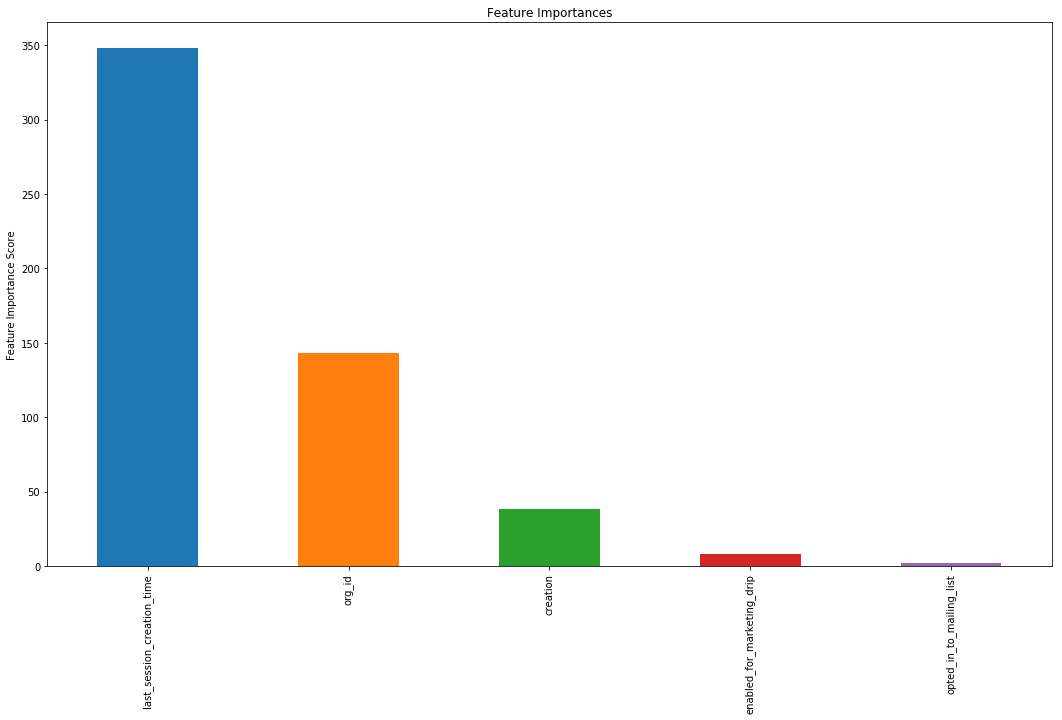

In [16]:
fig = plt.figure(figsize=(18, 10))
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

##  The model predicts an active user with 92% accuracy. At the same time "last session creation time" is the most important feature of this model, followed by the organization ID.